In [3]:
import pandas as pd
 
df_t= pd.read_csv('./Transactions.csv')
df_p= pd.read_csv('./Products.csv')
df_c= pd.read_csv('./Customers.csv')
 

In [4]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


In [6]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB


In [7]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


 Data Preprocessing

In [10]:
# Convert date columns to datetime
df_t['TransactionDate'] = pd.to_datetime(df_t['TransactionDate'])
df_c['SignupDate'] = pd.to_datetime(df_c['SignupDate'])

# Validate CustomerID and ProductID relationships
invalid_customers = df_t[~df_t['CustomerID'].isin(df_c['CustomerID'])]  # Check for orphaned CustomerIDs
invalid_products = df_t[~df_t['ProductID'].isin(df_p['ProductID'])]     # Check for invalid ProductIDs

# Verify TotalValue = Quantity * Price
df_t['CalculatedValue'] = df_t['Quantity'] * df_t['Price']
discrepancies = df_t[df_t['TotalValue'] != df_t['CalculatedValue']]     # Flag mismatches

Merge Data

In [11]:
# Merge transactions with customer and product data
merged_data = df_t.merge(df_c, on='CustomerID', how='left')\
                  .merge(df_p, on='ProductID', how='left', suffixes=('_Txn', '_Product'))

Key Analyses 

In [12]:
regional_sales = merged_data.groupby('Region')['TotalValue'].agg(['sum', 'mean']).reset_index()
print(regional_sales.sort_values(by='sum', ascending=False))

          Region        sum        mean
3  South America  219352.56  721.554474
1         Europe  166254.63  710.489872
2  North America  152313.40  624.235246
0           Asia  152074.97  697.591606


In [13]:
category_performance = merged_data.groupby('Category')['TotalValue'].sum().reset_index()
print(category_performance.sort_values(by='TotalValue', ascending=False))

      Category  TotalValue
0        Books   192147.47
2  Electronics   180783.50
1     Clothing   166170.66
3   Home Decor   150893.93


In [14]:
repeat_customers = df_t['CustomerID'].value_counts().gt(1).sum()
retention_rate = repeat_customers / df_c['CustomerID'].nunique()
print(f"Retention Rate: {retention_rate:.1%}")

Retention Rate: 93.5%


In [16]:
price_mismatch = merged_data[merged_data['Price_Txn'] != merged_data['Price_Product']]
mismatch_rate = len(price_mismatch) / len(merged_data)
print(f"Price Mismatch Rate: {mismatch_rate:.11%}")

Price Mismatch Rate: 0.00000000000%


<Axes: title={'center': 'Monthly Sales Trends'}, xlabel='TransactionMonth'>

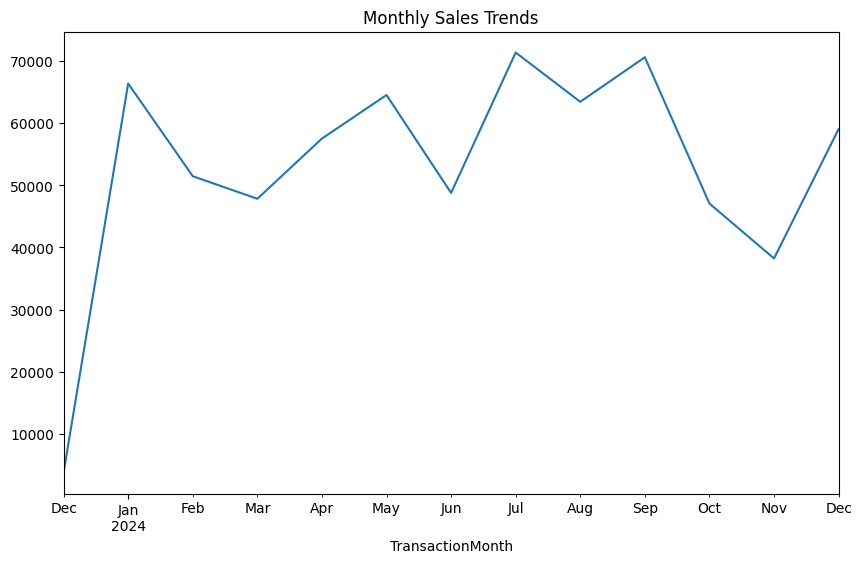

In [17]:
merged_data['TransactionMonth'] = merged_data['TransactionDate'].dt.to_period('M')
monthly_sales = merged_data.groupby('TransactionMonth')['TotalValue'].sum()
monthly_sales.plot(kind='line', title='Monthly Sales Trends', figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

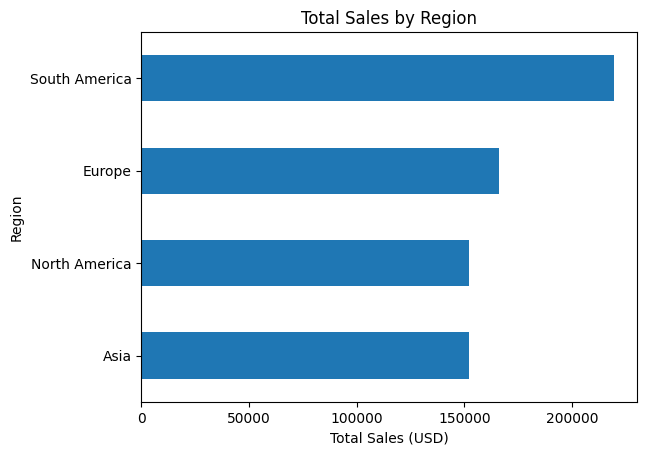

In [18]:
# Regional Sales Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
regional_sales.sort_values(by='sum').plot(kind='barh', x='Region', y='sum', legend=False)
plt.title('Total Sales by Region')
plt.xlabel('Total Sales (USD)')
plt.show()

 Customer Segmentation

 customers based on Recency (R), Frequency (F), and Monetary Value (M) to identify high-value vs. churned customers

In [19]:
# Calculate RFM metrics
snapshot_date = df_t['TransactionDate'].max() + pd.DateOffset(days=1)  # Latest transaction date
rfm = df_t.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'TransactionID': 'count',                                     # Frequency
    'TotalValue': 'sum'                                           # Monetary
}).rename(columns={
    'TransactionDate': 'Recency',
    'TransactionID': 'Frequency',
    'TotalValue': 'Monetary'
})

# Assign RFM scores (1-5, with 5 being best)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])
rfm['RFM_Score'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

# Merge with customer data to include Region
rfm = rfm.merge(df_c[['CustomerID', 'Region']], on='CustomerID', how='left')

# Top 10 high-value customers
high_value_customers = rfm.sort_values(by='RFM_Score', ascending=False).head(10)

In [21]:
high_value_customers

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Region
164,C0165,3,9,6708.10,5,5,5,15,South America
27,C0028,4,8,6819.57,5,5,5,15,Asia
3,C0004,5,8,5354.88,5,5,5,15,South America
98,C0099,5,8,6715.72,5,5,5,15,South America
100,C0101,1,8,5550.99,5,5,5,15,Asia
67,C0068,4,8,5950.42,5,5,5,15,North America
155,C0156,14,11,7634.45,5,5,5,15,North America
186,C0188,2,8,7111.32,5,5,5,15,South America
142,C0143,10,7,6044.63,5,4,5,14,Asia
144,C0145,33,8,5771.27,4,5,5,14,Asia


Transaction Hourly/Daily Patterns

Text(0, 0.5, 'Total Sales (USD)')

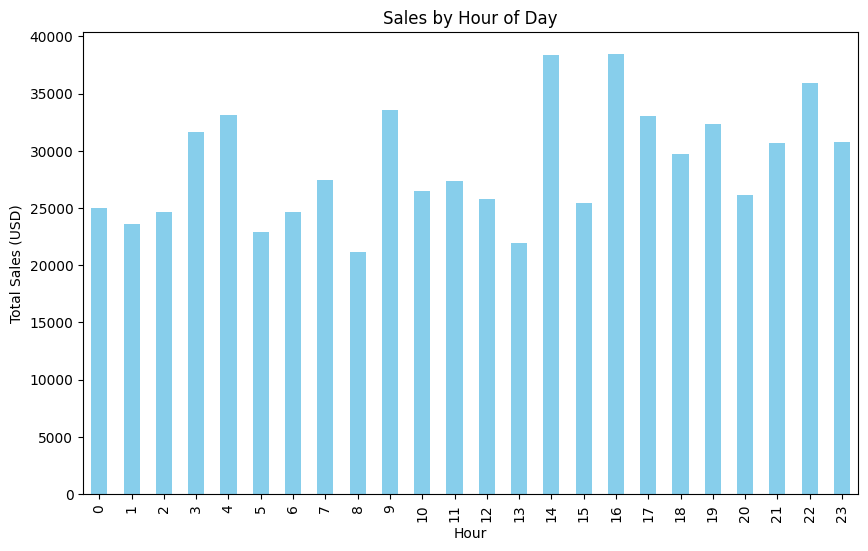

In [28]:
# Extract hour and day of week
merged_data['TransactionHour'] = merged_data['TransactionDate'].dt.hour
merged_data['TransactionDay'] = merged_data['TransactionDate'].dt.day_name()

# Hourly trends
hourly_sales = merged_data.groupby('TransactionHour')['TotalValue'].sum()
plt.figure(figsize=(10, 6))
hourly_sales.plot(kind='bar', color='skyblue')
plt.title('Sales by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Total Sales (USD)')

Customer Tenure vs. Spending

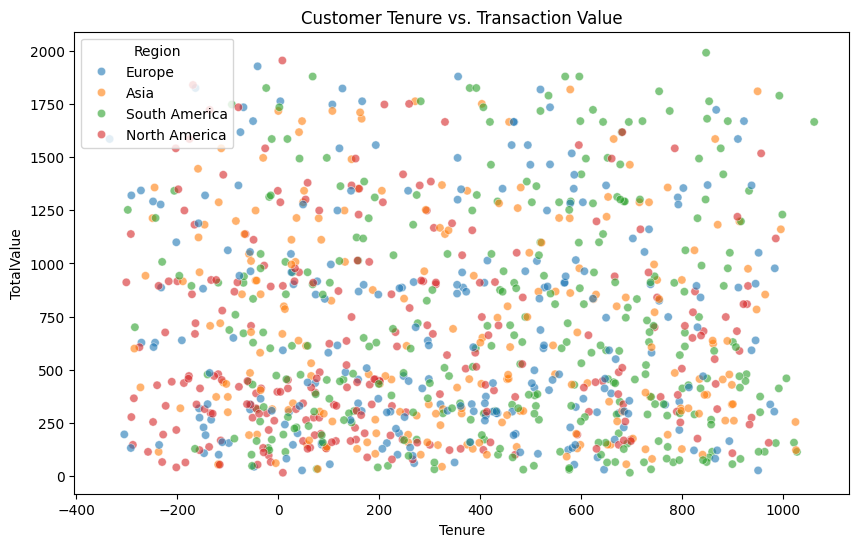

In [35]:
# Calculate tenure (days since signup)
merged_data['Tenure'] = (merged_data['TransactionDate'] - merged_data['SignupDate']).dt.days

# Tenure vs. spending
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tenure', y='TotalValue', data=merged_data, hue='Region', alpha=0.6)
plt.title('Customer Tenure vs. Transaction Value')
plt.show()

Product Price Distribution by Category

In [32]:
%pip install seaborn[stats]


     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     ---- ---------------------------------- 30.7/294.9 kB 1.4 MB/s eta 0:00:01
     ------------ -------------------------- 92.2/294.9 kB 1.1 MB/s eta 0:00:01
     ------------- ---------------------- 112.6/294.9 kB 939.4 kB/s eta 0:00:01
     ------------------------------ ------- 235.5/294.9 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/43.9 MB ? eta -:--:--
     ---------------------------------------- 0.3/43.9 MB 15.4 MB/s eta 0:00:03
     ---------------------------------------- 0.5/43.9 MB 6.0 MB/s eta 0:00:08
      --------------------------------------- 0.6/43.9 MB 4.9 MB/s eta 0:00:09
      --------------------------------------- 1.1/43.9 MB 6.1 MB/s eta 0:00:08
     - -------------------------------------- 1.5/43.9 MB 6.7 MB/s eta 0:00:07
     - -------------------------------------- 1.9/43.9 MB 6


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\write\AppData\Local\Temp\ipykernel_13428\2407758432.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Price_Product', data=merged_data, palette='Blues')


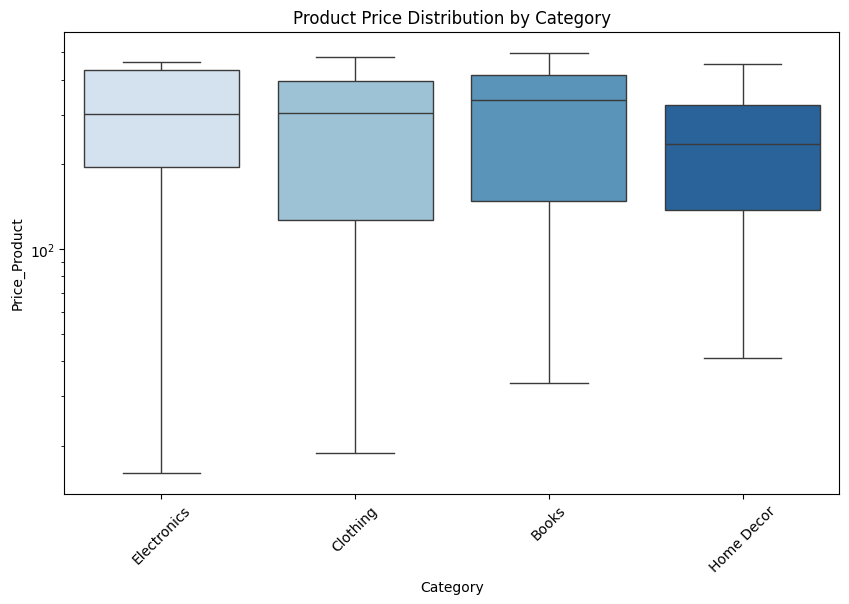

In [34]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Price_Product', data=merged_data, palette='Blues')
plt.yscale('log')  # For skewed distributions
plt.title('Product Price Distribution by Category')
plt.xticks(rotation=45)
plt.show()

Outlier Detection

In [38]:
# Flag transactions with Quantity > 3 standard deviations
Q1 = df_t['Quantity'].quantile(0.25)
Q3 = df_t['Quantity'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_t[(df_t['Quantity'] > Q3 + 1.5*IQR)]
print(f"Outliers (bulk purchases): {len(outliers)}")

Outliers (bulk purchases): 0
